# SiamMAE

In [39]:
import torch
from mae.models_mae import  mae_vit_base_patch16

In [40]:
from dataset_loader.dataset import get_kinetics_dataset, unnormalize_for_plot, unnormalize

In [41]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    
print("Using device =", device)

Using device = cuda


In [42]:
data = get_kinetics_dataset("./dataset/")

Loading dataset from ./dataset/
min_gap: 2, max_gap: 10, temporal_dim: -3, repeated_sampling: 3


In [43]:
print(data.num_videos)

711


In [44]:
BATCH_SIZE = 8

data_loader = torch.utils.data.DataLoader(
    data,
    batch_size=BATCH_SIZE,
)

torch.Size([8, 4, 3, 224, 224])


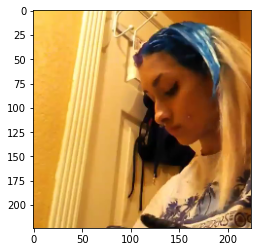

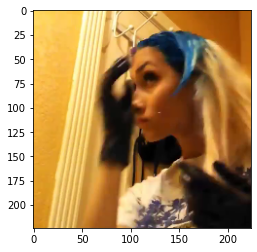

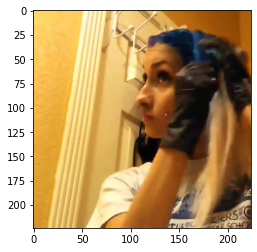

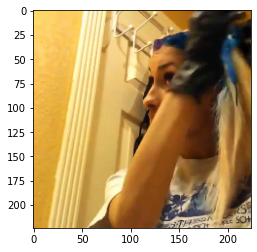

In [45]:
# torch.Size([3, 3, 224, 224])
from dataset_loader.dataset import unnormalize


for batch in data_loader:
    print(batch["video"].shape)
    # torch.Size([8, 4, 3, 224, 224])
    # [BATCH_SIZE x Frames x Channel x Height x Width ]

    import matplotlib.pyplot as plt
    for i in range(batch["video"].shape[1]):
        plt.imshow(unnormalize_for_plot(batch["video"][0][:][i]))
        plt.show()
    break

In [46]:
mae_model = mae_vit_base_patch16().to(device)
mae_model2 = mae_vit_base_patch16().to(device)

In [47]:
from mae.models_mae import MaskedAutoencoderViT
from functools import partial
from torch import nn

# model = MaskedAutoencoderViT(
# patch_size=16, embed_dim=768, depth=12, num_heads=12,
# decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
# mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)

# Doubled patch_size since we have 2 images
decoder = MaskedAutoencoderViT(
        patch_size=16, embed_dim=768, depth=12, num_heads=12,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6))

In [48]:
# "We use the ViT-S/16 model for most of our experiments as it is similar to ResNet-50 in
# terms of the number of parameters (21M vs 23M) and allows for fair comparisons across different
# self-supervised learning and correspondence learning methods."

In [49]:
# A cross decoder consists of decoder blocks with only cross-attention layers, where tokens from f2
# attend to the tokens from f1.
class CrossDecoder(torch.nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(CrossDecoder, self).__init__()
        self.multihead_attn = torch.nn.MultiheadAttention(embed_dim, num_heads)

    def forward(self, f1, f2):
        # f1: ([BATCH_SIZE, 196, N])
        # f2: ([BATCH_SIZE, 50, N])

        # Reshape f1 and f2 to fit the input shape requirement of MultiheadAttention
        # which is (seq_len, batch_size, embed_dim)
        f1 = f1.transpose(0, 1)
        f2 = f2.transpose(0, 1)

        # MultiheadAttention takes in the query, key, value. Here we use f2 to attend to f1
        attn_output, _ = self.multihead_attn(f2, f1, f1)

        # Reshape the output back to the original shape
        attn_output = attn_output.transpose(0, 1)

        return attn_output

In [57]:
class SiamMAE(torch.nn.Module):
    def __init__(self, mae, mae2):
        super().__init__()
        self.mae = mae
        self.mae2 = mae2
        self.cross_decoder = CrossDecoder(embed_dim=768, num_heads=12)

    def forward(self, x):
        frame_one = x[:, 0, :, :, :]
        # * Currently we assume that we take the next frame always. 
        # * This could be improved
        frame_rest = x[:, 1, :, :, :]

        frame_one_x, _frame_one_mask, frame_one_ids = self.mae.forward_encoder(frame_one, mask_ratio = 0)
        frame_one_x = frame_one_x[:, 1:, :]

        frame_rest_x, frame_rest_mask, frame_rest_ids = self.mae2.forward_encoder(frame_rest, mask_ratio = 0.75)

        cross_decoded = self.cross_decoder(frame_one_x, frame_rest_x)
        
        return self.mae2.forward_decoder(cross_decoded, frame_rest_ids)


In [58]:
first_batch = next(iter(data_loader))
siam = SiamMAE(mae_model,mae_model2).to(device)

frame = siam(first_batch["video"].to(device))
frame.shape

Cross decoder: torch.Size([8, 50, 768])
Initial x was : torch.Size([8, 50, 768])
Post decoder embed x was : torch.Size([8, 50, 512])
Mask tokens was : torch.Size([8, 147, 512])
Post mask tokens x was : torch.Size([8, 196, 512])
Post gather x was : torch.Size([8, 196, 512])
Post cat x was : torch.Size([8, 197, 512])
decoder_pos_embed was : torch.Size([1, 197, 512])
Post pos embed x was : torch.Size([8, 197, 512])


torch.Size([8, 196, 768])